In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as shc
import umap
from sklearn.cluster import KMeans

In [2]:
df_eda = pd.read_csv("data/eda_dataset.csv", index_col=0)
df_pca = pd.read_csv("data/pca_dataset.csv", index_col=0)

In [4]:
from sklearn.ensemble import IsolationForest

# 1. Обучение Isolation Forest
# contamination=0.05 означает, что мы ожидаем примерно 5% аномалий (около 10-12 стран)
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
outlier_preds = iso_forest.fit_predict(df_pca) # -1 = аномалия, 1 = норма

# 2. Создаем список аномалий
df_anomalies = df_eda.copy() # Берем исходные (восстановленные) данные для интерпретации
df_anomalies['Anomaly'] = outlier_preds
df_anomalies['Anomaly_Score'] = iso_forest.decision_function(df_pca) # Чем ниже, тем аномальнее

# Фильтруем только выбросы
outliers = df_anomalies[df_anomalies['Anomaly'] == -1].sort_values('Anomaly_Score')

print(f"Найдено аномальных стран: {len(outliers)}")
print("\n--- Топ-10 самых нестандартных стран (по версии IsolationForest) ---")
print(outliers.index.tolist()[:10])

# 3. Интерпретация: Почему они попали в выбросы?
# Сравним средние показатели выбросов со средними показателями всего мира
global_mean = df_eda.mean()
outlier_mean = outliers.drop(columns=['Anomaly', 'Anomaly_Score']).mean()

# Считаем отклонение в процентах
diff = ((outlier_mean - global_mean) / global_mean) * 100
diff = diff.sort_values(key=abs, ascending=False).head(10) # Топ-10 отличий

print("\n--- Чем аномалии отличаются от среднего по миру? (Топ отличий в %) ---")
print(diff)


Найдено аномальных стран: 14

--- Топ-10 самых нестандартных стран (по версии IsolationForest) ---
['ZWE', 'SDN', 'SWZ', 'LUX', 'KIR', 'HKG', 'DJI', 'SMR', 'LBN', 'TUV']

--- Чем аномалии отличаются от среднего по миру? (Топ отличий в %) ---
inflation_rate                       420.594141
exports_percent_gdp                   77.591820
unemployment_rate                     71.511448
imports_percent_gdp                   71.366007
education_expenditure_percent_gdp     29.990503
probability_of_dying                  24.017187
industry_value_added_percent_gdp     -22.123563
log_air_pollution                    -21.443093
infant_mortality_rate                 17.457295
manufacturing_percent_gdp            -13.987792
dtype: float64


In [9]:
df_profile = df_eda.copy()
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_profile['Cluster'] = kmeans.fit_predict(df_pca)
cluster_profiles = df_profile.groupby('Cluster').median(numeric_only=True)
print("--- Медианный портрет кластеров (Original Values) ---")
cluster_profiles.T

--- Медианный портрет кластеров (Original Values) ---


Cluster,0,1,2,3
inflation_rate,5.087255,5.748603,6.275471,3.654354
unemployment_rate,5.678151,8.742030,4.837400,5.094000
exports_percent_gdp,27.296030,37.902505,24.881018,50.871058
imports_percent_gdp,29.015030,59.382772,35.073870,48.893527
gross_savings_percent_gdp,24.825968,19.120057,18.643457,24.134832
education_expenditure_percent_gdp,3.730847,4.291303,3.400585,4.832119
health_expenditure_percent_gdp,5.435786,6.709507,4.516812,9.038562
urban_population_percent,59.171231,63.597000,38.193600,81.883600
manufacturing_percent_gdp,14.680742,4.976206,10.907465,11.797895
industry_value_added_percent_gdp,29.925717,14.842203,25.273637,23.614788


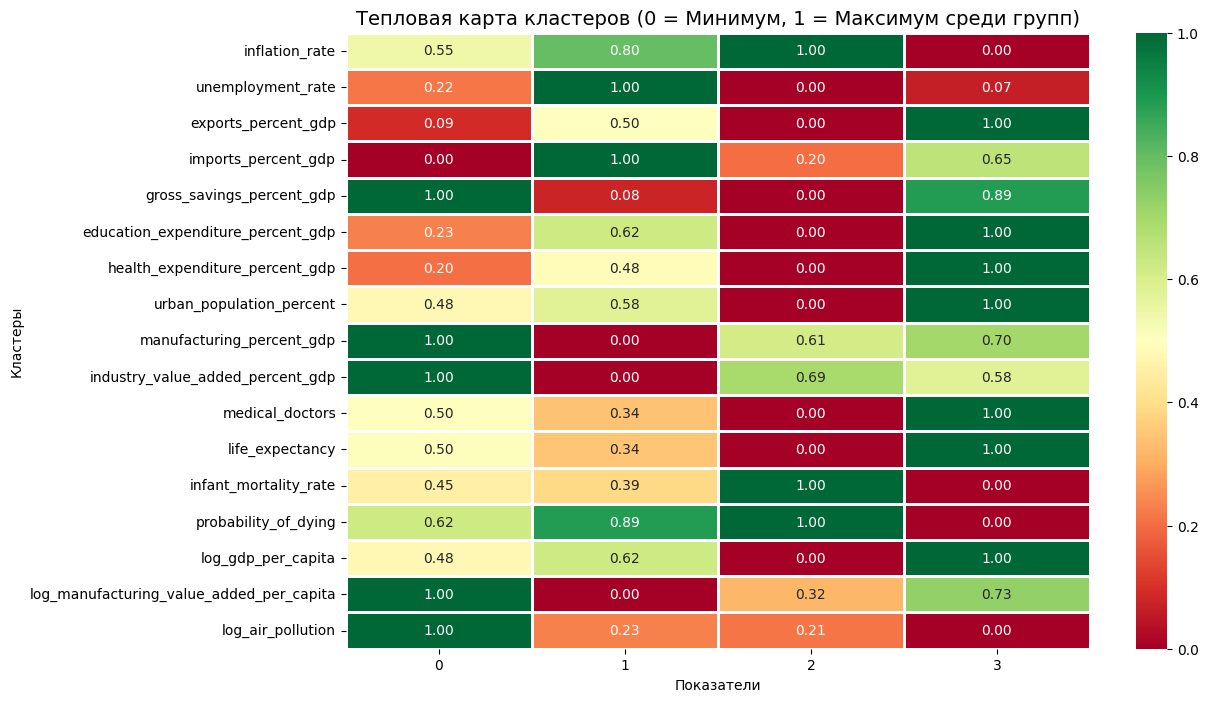

In [10]:
scaler_viz = MinMaxScaler()
profiles_norm = pd.DataFrame(scaler_viz.fit_transform(cluster_profiles), 
                             columns=cluster_profiles.columns, 
                             index=cluster_profiles.index)
plt.figure(figsize=(12, 8))
sns.heatmap(profiles_norm.T, cmap='RdYlGn', annot=True, fmt='.2f', linewidths=1)
plt.title('Тепловая карта кластеров (0 = Минимум, 1 = Максимум среди групп)', fontsize=14)
plt.xlabel('Показатели')
plt.ylabel('Кластеры')
plt.show()



In [7]:
print("\n--- Примеры стран в каждом кластере ---")
for i in range(4):
    countries = df_profile[df_profile['Cluster'] == i].index.tolist()
    sample = np.random.choice(countries, min(5, len(countries)), replace=False)
    print(f"Cluster {i} ({len(countries)} стран): {', '.join(sample)}")



--- Примеры стран в каждом кластере ---
Cluster 0 (92 стран): LIE, RUS, ECS, EAR, KHM
Cluster 1 (69 стран): NRU, MDV, FRO, IMN, MNE
Cluster 2 (53 стран): COM, UGA, TLS, RWA, HTI
Cluster 3 (52 стран): SWE, FRA, NOR, ARE, ITA
